# Assignment 3: Linear Regression

For this assignment, you may `numpy`, `pandas`, and packages from the Python standard library.

List your team members (name, matriculation number, course of study) in the following cell:

* Your names here

## Task 1: Linear Regression - Theory

Hint: You can enter math in LaTeX style using single dollar signs for inline math, e.g. $x = \cos{\alpha}$, and double dollar signs for equations, e.g.
$$
\begin{align}
\dot{x} &= Ax + Bu\\
y &= Cx + Du
\end{align}
$$

1\) Linear regression can include nonlinear features, why is it still called linear regression? In what sense is it linear?

*Your answer*

- It is linear in its weights $\beta$.
- The input data $X$ can be replaced by arbitrary non-linear features.

2\) For calculating optimal parameters $\hat{\beta}$ the inverse of $X^\top X$  has to be calculated. When would this matrix be singular?

*Your answer*

Solution: If the columns of $X$ are not linearly independent, e.g. `X[:, 1] = 3*X[:, 0]`

3\) Assume optimization of the weights $\hat{\beta}$ fails due to singularity of $X^\top X$. Explain how you would modify $X$ to avoid this problem.

*Your answer*

Solution: Compute pairwise linear correlation between each column of $X$. Eliminate columns that have very strong correlation.

4\) Why does the optimization problem for $L_1$-regularization (Lasso) generally not have a closed form solution?

*Your answer*

Solution: $\vert \beta \vert$ is not continuously differentiable.

5\) Let us consider a time-series regression problem.

We will look at the model of a lake. Given the water temperature, water conductivity, water alkalinity, NO3 content, and total hardness of the water, we want to predict the dissolved oxygen and algae content in the lake.

The input is defined by $X \in \mathbb{R}^{T \times 5}$ and the output is defined by $Y \in \mathbb{R}^{T \times 2}$. $T$ is the number of time steps, where each time steps corresponds to a month.

We want to predict the output at time step $t+1$ given the input and output at time step $t \in \{0, \dots, T-1 \}$. Formally, defined we need to learn the following function $f$:
$$
\hat{y}_{t+1} = f(x_{t}, y_{t})
$$
where $x_{t}$ is the $t$-th row of $X$ and $y_{t}$ is the $t$-th row of $Y$.

a\) Formally define a linear regression model to estimate the function $f$.

*Your answer*

$\hat{y}_{t+1} = A \begin{bmatrix} x_t \\ y_t\end{bmatrix} + b$

with $A \in \mathbb{R}^{2 \times (5+2)}$ and $b \in \mathbb{R}^2$.

b\) Dynamic systems, such as the lake in our example, often contain dynamics that are difficult or impossible to measure directly. However, these dynamics can be inferred from long-term time dependencies. For example, the water temperature measured two months ago might still have an impact on the algae content of the lake.

A common feature introduced in models of dynamic systems are lag variables. In this task, you will extend your linear regression model from (a) to include the inputs and outputs of the last two months $t$ and $t-1$  to predict the output at month $t+1$. In this case, the features at time step $t-1$ would be considered lag variables.

Update the function signature of $f$ to match the described prediction task. Then, formally define the linear regression model including the lagged variables.

*Your answer*

$f$ including lagged variables:
$$
\hat{y}_{t+1} = f(x_{t}, x_{t-1}, y_{t}, y_{t-1}) \text{ with } t \in \{1, \dots, T-1 \}
$$
Linear lag model:
$$
\hat{y}_{t+1} = A^{(0)} \begin{bmatrix} x_t \\ y_t\end{bmatrix} + A^{(1)} \begin{bmatrix} x_{t-1} \\ y_{t-1}\end{bmatrix} + b
$$
with $A^{(i)} \in \mathbb{R}^{2 \times 7}$ for $i=0,1$ and $b \in \mathbb{R}^2$.



## Task 2: Ridge Regression for Time-Series Prediction

In this task, you will implement and evaluate a ridge regression model at the example of the lake model from the previous task. Make sure the provided `lake.dat` file is in the same directory as the Jupyter notebook.

You can find the original data including references here: [DaISy - Data of a simulation of the western basin of Lake Erie](https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def load_lake_data():
    with open('lake.dat') as f:
        data = np.loadtxt(f)
    X = data[:, 6:11]
    Y = data[:, 23:25]
    return X, Y

def train_test_split(X, Y, train_fraction):
    cutoff_idx = int(train_fraction * X.shape[0])
    X_train, Y_train = X[:cutoff_idx], Y[:cutoff_idx]
    X_test, Y_test = X[cutoff_idx:], Y[cutoff_idx:]

    return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = train_test_split(*load_lake_data(), train_fraction=0.7)
print(f'Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}')

Train samples: 39, Test samples: 18


Training data is stored in `X_train` and `Y_train`. Test data is stored in `X_test` and `Y_test`.

1\) Create a plot that shows all inputs and outputs of the training dataset over time. For each variable a separate subplot should be created. Time should be displayed along the x-axis, while the value of each variable should be displayed along the y-axis.

*Hint:* Use `plt.subplots(n, sharex=True)` to create `n` plots that are synchronized along the x-axis.

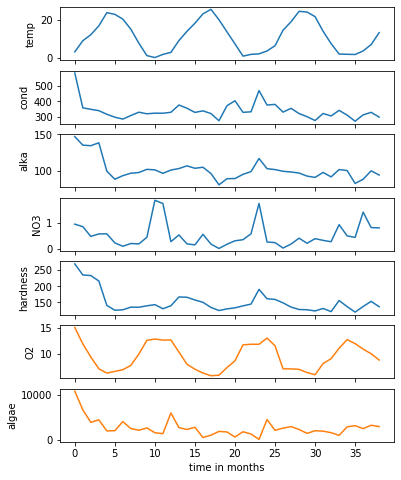

In [3]:
# Your code here

input_names = ('temp', 'cond', 'alka', 'NO3', 'hardness')
output_names = ('O2', 'algae')

fig, ax = plt.subplots(X_train.shape[1] + Y_train.shape[1], sharex=True, figsize=(6, 8))
XY = np.hstack((X_train, Y_train))
for idx, name in enumerate(input_names + output_names):
    line_color = 'C0' if idx < X_train.shape[1] else 'C1'
    ax[idx].plot(XY[:, idx], color=line_color)
    ax[idx].set_ylabel(name)
ax[-1].set_xlabel('time in months');

2\) The `make_features` takes as input a matrix of inputs `X` and a matrix of outputs `Y`, as well as the arguments `feature_type` and `lag`.
It computes a features used as input for a linear regression.


`X` has the shape `(T, 5)` and `Y` has the shape `(T, 2)` where `T` is a number of time steps.
`feature_type` is a string with either value `lin` or `quad` whether only linear features or also quadratic features should be computed. `lag` is a boolean that determines whether the lag variables for `t-1`should be included (see Task 1.5).


If `lag` is False, the returned feature matrix has shape `(T, D)` where `D` depends on the choice of `feature_type`.
For `feature_type=lin` and `lag=False`, `D` equals `5+2+1`, for `feature_type=lin` and `lag=True`, `D` equals `2*(5+2)+1`.
If `lag` is True, the returned feature matrix has shape `(T-1, D)`, since the additional lag variable prevents the creation of a feature for time step $t=0$.


Extend the `make_features` method to also compute quadratic features (`ftype = 'quad'`) for both `lag=False` and `lag=True`.


In [4]:
def make_features(X, Y, feature_type='lin', lag=False):
    if feature_type == 'lin':
        if lag:
            Phi = np.hstack((
                np.ones((X.shape[0]-1, 1)), # bias/intercept term
                X[1:], # x_t
                X[:-1], # x_{t-1}
                Y[1:], # y_t
                Y[:-1] # y_{t-1}
            ))
        else:
            Phi = np.hstack((
                np.ones((X.shape[0], 1)), # bias/intercept term
                X, # x_t
                Y # y_t
            ))
    elif feature_type == 'quad':
        # Your code here
        #raise NotImplementedError()
        features = [
            np.ones((X.shape[0]-1, 1))  if lag else np.ones((X.shape[0], 1))
        ]
        XY = np.hstack((X, Y))
        if lag:
            features.append(XY[1:])
            features.append(XY[:-1])
        else:
            features.append(XY)
        for i in range(XY.shape[1]):
            for j in range(i, XY.shape[1]):
                if lag:
                    features.append((XY[1:, i] * XY[1:, j]).reshape(-1, 1))
                    features.append((XY[:-1, i] * XY[:-1, j]).reshape(-1, 1))
                else:
                    features.append((XY[:, i] * XY[:, j]).reshape(-1, 1))
        Phi = np.hstack(features)
    else:
        raise ValueError(f'feature_type is not implemented for {feature_type}')

    return Phi


3\) Implement ridge regression (linear regression using $L_2$-regularization) to fit a function with the regularization parameter `lambda_`, feature type `feature_type` and optional lag variable `lag`. Use the previously implemented `make_feature` function to allow for different features types and lag variables.

Fill out the methods in `RidgeRegression` to train (`fit`) and predict (`predict`). Feel free to introduce new fields and methods based on your needs, but the methods `fit` and `predict` are required and their interface should not be changed. You need to store the vector of regression coefficients in the field `self.beta`. Before calculating the inverse check if the determinant is non-zero.

In [5]:
class RidgeRegression:
    def __init__(self, lambda_, feature_type='lin', lag=False):
        self.lambda_ = lambda_
        self.feature_type = feature_type
        self.lag = lag
        self.beta = None  # Learned regression coefficients.

    def fit(self, X, Y):
        """
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The goal is to predict the output at t+1 given the input and output at t (or at t and t-1 for lag=True).
        Hint: Your prediction target during training is Y[1:] (or Y[2:] for lag=True).
        """
        # Your code here
        #raise NotImplementedError()

        Phi = make_features(X[:-1], Y[:-1], feature_type=self.feature_type, lag=self.lag)
        k = Phi.shape[1]
        I = np.eye(k)
        # \beta_0 is not regularized
        I[0, 0] = 0

        # check if inverse exists
        if np.linalg.det((Phi.T @ Phi)) == 0:
            raise Exception(f'The Matrix Phi.T*Phi is singular and cannot be inverted.')
        else:
            # Computing the inverse can be inefficient and inaccurate
            # an alternative to speed up computation would be to solve the linear equation
            # Ax=b, where A = \Phi^{\top}\Phi + \lambda I and b = \Phi^{\top} y
            # self.beta = np.linalg.solve((Phi.T @ Phi) + (self.lambda_ * I), Phi.T @ y)
            Y = Y[2:] if self.lag else Y[1:]
            self.beta = np.linalg.inv((Phi.T @ Phi) + (self.lambda_ * I)) @ Phi.T @ Y
            #self.beta = np.linalg.solve((Phi.T @ Phi) + (self.lambda_ * I), Phi.T @ Y)
            
    def predict(self, X, Y):
        """
        Predict the next time step for each given row.
        X is the time series of inputs with shape (T, 5)
        Y is the time series of outputs with shape (T, 2)
        The output is of shape (T, 2) (or (T-1, 2) for lag=True).
        """
        # Your code here
        #raise NotImplementedError()

        Phi = make_features(X, Y, feature_type=self.feature_type, lag=self.lag)

        return Phi.dot(self.beta)

4\) Evaluate your regression model with linear features (`feature_type='lin'`), no lag (`lag=False`) and no regularization (`lambda_=0.0`). Train the model on `X_train, Y_train` and evaluate it on `X_test, Y_test`.

Compute and report the RMSE separately for both output variables. There should be an error value for dissolved oxygen and algae.

Plot the true and predicted output variables over time similar to task 2.1. The true and predicted output of a variable should be shown in the same subplot for easy comparison.

RMSE (Dissolved oxygen: 2.226517349112996
RMSE (Algae): 1644.5457422400862


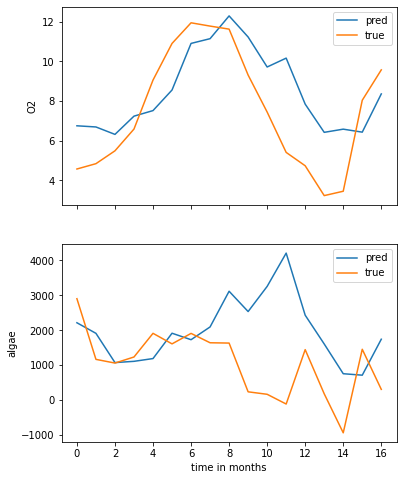

In [6]:
# Your code here

model = RidgeRegression(lambda_=0.0, feature_type='lin', lag=False)
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test[:-1], Y_test[:-1])
Y_true = Y_test[1:]

rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))
print(f'RMSE (Dissolved oxygen: {rmse[0]}')
print(f'RMSE (Algae): {rmse[1]}')

fig, ax = plt.subplots(len(output_names), sharex=True, figsize=(6, 8))
for idx, name in enumerate(output_names):
    ax[idx].plot(Y_pred[:, idx], label='pred')
    ax[idx].plot(Y_true[:, idx], label='true')
    ax[idx].set_ylabel(name)
    ax[idx].legend()
ax[-1].set_xlabel('time in months');

### Discussion (Added 2022-05-18)

The learned model is outperformed on test set by simply copying the outputs of the previous time step. The model would be defined as follows:
$$
\begin{align}
\hat{y}(t+1) = y(t)
\end{align}
$$
This corresponds to the following linear regression model:
$$
\begin{align}
\hat{y}(t+1) = \mathbf{I} y(t) + \mathbf{0} x(t)
\end{align}
$$
where $\mathbf{I}$ is the identity matrix and $\mathbf{0}$ is the zero matrix.

As you can see here, the linear regression model overfits on the training data:

In [7]:
print('Linear Regression')

model = RidgeRegression(lambda_=0.0, feature_type='lin', lag=False)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train[1:-1], Y_train[1:-1])
Y_true = Y_train[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Train:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')

Y_pred = model.predict(X_test[1:-1], Y_test[1:-1])
Y_true = Y_test[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Test:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')
print()

print('Copy Outputs')

Y_pred = Y_train[1:-1]
Y_true = Y_train[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Train:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')

Y_pred = Y_test[1:-1]
Y_true = Y_test[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Test:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')

Linear Regression
Train:
- RMSE (Dissolved oxygen: 1.0562149961866727
- RMSE (Algae): 974.7193693066225
Test:
- RMSE (Dissolved oxygen: 2.2294259818823647
- RMSE (Algae): 1686.4166405083313

Copy Outputs
Train:
- RMSE (Dissolved oxygen: 1.5975215442441846
- RMSE (Algae): 1630.2332756409353
Test:
- RMSE (Dissolved oxygen: 1.7944528877209343
- RMSE (Algae): 1062.7412428567688


Regularization can counteract this problem to some degree. Lets compute the RMSE for our best performing regularized linear model, which we have identified in Task 3:

In [8]:
print('Linear Lag Ridge Regression')

model = RidgeRegression(lambda_=33.0, feature_type='lin', lag=True)
model.fit(X_train, Y_train)

Y_pred = model.predict(X_train[:-1], Y_train[:-1])
Y_true = Y_train[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Train:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')

Y_pred = model.predict(X_test[:-1], Y_test[:-1])
Y_true = Y_test[2:]
rmse = np.sqrt(np.mean((Y_true - Y_pred)**2, axis=0))

print('Test:')
print(f'- RMSE (Dissolved oxygen: {rmse[0]}')
print(f'- RMSE (Algae): {rmse[1]}')
print()

Linear Lag Ridge Regression
Train:
- RMSE (Dissolved oxygen: 0.7453537025967383
- RMSE (Algae): 965.0865777311327
Test:
- RMSE (Dissolved oxygen: 1.801588460694909
- RMSE (Algae): 1385.099275278409



Even with regularization, we can see overfitting on the training data.
Additionally, we can see that while our model performance is closer to the copy baseline, we still perform worse.

### Numerical Benefits of Ridge Regression

The condition of a matrix gives a measure of how accurately its inverse can be computed. When we solve the least-squares problem for linear regression, we need to compute the inverse of $\Phi^\top \Phi$. Therefore we want this matrix to not be ill-conditioned. 

The condition number is given by
$$
C(M) = \frac{\lvert\lambda_\max(A)\rvert}{\lvert\lambda_\min(A)\rvert}
$$
where $\lambda_\max(A)$ and $\lambda_\min(A)$ are the largest and smallest eigenvalue of matrix $A$ respectively.

When $\lambda_\min(A)$ is zero, $A$ is singular and does not have an inverse. If the ratio between largest and smallest eigenvalue is large, then $A$'s condition number is large and the matrix is ill-conditioned. For very large condition numbers, the matrix is "almost" singular and therefore sensitive to numerical errors. The condition number of a matrix corresponds to how strongly the matrix responds to small changes in its input. A larg condition number implies large changes in output for small inputs.

We can compute the condition number for our example using a linear model with linear features and no regularization, as follows:

In [9]:
XY = np.hstack((X_train, Y_train))
np.linalg.cond(XY.T @ XY)

80637514.35398312

We can see that the condition of this matrix is extremely large and the matrix $\Phi^\top \Phi$ is almost singular. Accordingly, computing the inverse will be prone to numerical inaccuracies.

We can improve the condition of $\Phi^\top \Phi$ via regularization and via normalization of the features in $\Phi$.

Ridge regularization shifts the eigenvalues of $\Phi^\top \Phi$ by its regularization factor and can thereby improve the condition of the matrix. The to be inverted matrix of ridge regression is given by:
$$
\begin{align}
\Phi^\top \Phi + \gamma \mathbf{I}
\end{align}
$$
The diagonal matrix $\gamma \mathbf{I}$ adds the regularization term $\gamma$ to each eigenvalue of  $\Phi^\top \Phi$. Accordingly, the smallest and largest eigenvalue will converge towards each other for infinitely large $\gamma$. As a consequence, for increasing gamma the condition of the matrix will converge towards $1$.

We can see this behavior for our example as follows:

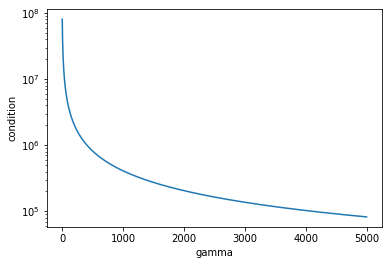

In [10]:
gammas = np.arange(0.0, 5000.0, 1.0)
cond = []
for gamma in gammas:
    M = XY.T @ XY + gamma * np.eye(XY.shape[1])
    cond.append(
        np.linalg.cond(M)
    )
fig, ax = plt.subplots()
ax.plot(gammas, cond)
ax.set_yscale('log')
ax.set_xlabel('gamma')
ax.set_ylabel('condition');

Normalization can also improve the condition of a matrix as it scales the eigenvalues of the matrix, thereby also scaling the condition to a usually smaller value.

We can see this for our example:

In [11]:
XY_mean = np.mean(XY, axis=0)
XY_std = np.std(XY, axis=0)
XY_normed = (XY - XY_mean) / XY_std
np.linalg.cond(XY_normed.T @ XY_normed)

137.27238340794744

While the condition number is still large, it is significantly smaller than for the original matrix. Accordingly, numerical inaccuracies when computing the inverse are reduced.

## Task 3: Hyperparameter-Optimization with Grid Search

(Not required for B.Sc. Data Science)

In this task, you will look for the optimal combination of hyperparameters for your implemented ridge regression.

Grid search is a simple hyperparameter optimization algorithm, where you train and evaluate your model for each possible combination of hyperparameters out of a predefined set of hyperparameters.
For example, if you apply grid search over kNN, you might search over $k \in \{1, 3, 5\}$ and over weighting schemes $\{\text{uniform}, \text{euclidean}\}$. These choices would result in a total of 6 combinations of hyperparameters.

a\) You will implement a grid search algorithm for your hyperparameters. Search over feature types `lin` and `quad`, both options for `lag`, and various values for `lambda_`. *Hint:* You will have to try some very large values of `lambda_`, since the input and output data is not normalized.

b\) For each combination of feature type and lag, you will create a plot showing the regularization parameter `lambda_` on the x-axis using a logarithmic scale and the RMSE on the y-axis. There should be a total of four plots.

c\) Report the best performing combination of feature type, lag, and regularization.

d\) Finally, shortly discuss your results. How does the regularization and error term relate to each other? Why do you think this behavior occurs?

*Hint:* There are two output variables and accordingly two errors for each evaluated model. To simplify the evaluation and hyperparameter optimization, you will have to average these errors to a single error. Note that the output variables have different magnitudes and units, therefore you will have to normalize the variables before computing such an averaged error.

Best combination of hyperparameters: lag=True, feature=lin, lambda=33.0


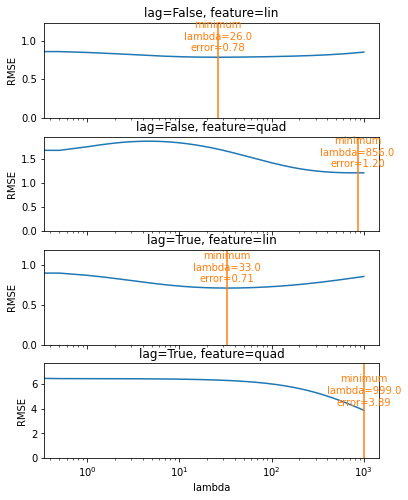

In [12]:
# Your code here
class Normalizer:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, Y):
        self.means = np.mean(Y, axis=0)
        self.stds = np.std(Y, axis=0)

    def transform(self, Y):
        return (Y - self.means) / self.stds


def train_evaluate(X_train, Y_train, X_test, Y_test, lambda_, feature_type, lag):
    norm = Normalizer()
    norm.fit(Y_train)

    model = RidgeRegression(lambda_=lambda_, feature_type=feature_type, lag=lag)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test[:-1], Y_test[:-1])

    # To ensure comparable error terms, cut off the first prediction when lag is not used.
    # This way the first term is not present for both lag=False and lag=True.
    if not lag:
        Y_pred = Y_pred[1:]
    Y_true = Y_test[2:]
    # Normalize outputs and compute aggregated RMSE over both variables.
    rmse = np.sqrt(np.mean((norm.transform(Y_true) - norm.transform(Y_pred))**2))
    return rmse


lag_options = (False, True)
feature_options = ('lin', 'quad')
lambda_options = (
    tuple(np.arange(0.0, 100.0, 0.5)) +
    tuple(np.arange(100.0, 1000.0, 1.0))
)

results = dict()
for lag in lag_options:
    for feature in feature_options:
        results[(lag, feature)] = []
        for lambda_ in lambda_options:
            rmse = train_evaluate(X_train, Y_train, X_test, Y_test, lambda_, feature, lag)
            results[(lag, feature)].append(rmse)

best_lag, best_type = min(results.items(), key=lambda t: min(t[1]))[0]
best_lambda = lambda_options[np.argmin(results[(best_lag, best_type)])]
print(f'Best combination of hyperparameters: lag={best_lag}, feature={best_type}, lambda={best_lambda}')

fig, ax = plt.subplots(len(results.keys()), sharex=True, figsize=(6, 8))
for idx, ((lag, feature), rmses) in enumerate(results.items()):
    ax[idx].plot(lambda_options, rmses)
    ax[idx].set_title(f'lag={lag}, feature={feature}')
    ax[idx].set_ylabel('RMSE')
    ax[idx].set_ylim((0.0, 1.5*np.mean(rmses)))
    ax[idx].set_xscale('log')
    min_x = lambda_options[np.argmin(rmses)]
    min_y = np.min(rmses)
    ax[idx].axvline(min_x, color='C1')
    ax[idx].text(min_x, 1.1*min_y, f'minimum\nlambda={min_x}\nerror={min_y:.2f}', color='C1', horizontalalignment='center')
ax[-1].set_xlabel('lambda');